In this tutorial, we would like to implement VALMOD algorithm proposed in paper [VALMOD](https://arxiv.org/pdf/2008.13447.pdf), and reproduce its results as closely as possible.

The **VAriable Length MOtif Discovery (VALMOD)** algorithm takes time series `T` and a range of subsequence length `[min_m, max_m]`, and find motifs and discords.

In [1]:
%matplotlib inline

import stumpy
from stumpy import stump, core, config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [4]:
stump(np.random.rand(10), 3)

array([[0.8774290881094438, 3, -1, 3],
       [0.22840038810292498, 4, -1, 4],
       [0.012465907727357997, 5, 0, 5],
       [0.8774290881094438, 0, 0, 6],
       [0.1871064481158026, 6, 1, 6],
       [0.012465907727357997, 2, 2, 7],
       [0.1871064481158026, 4, 4, -1],
       [0.23027056533433626, 5, 5, -1]], dtype=object)

# 1- Introduction

**Notation:** $T_{i,m} = T[i:i+m]$ is a subsequence of `T` that starts at index `i` and has length `m`. 

## Motif discovery

For a given motif pair $\{T_{idx,m},T_{nn\_idx,n}\}$, Motif set $S^{m}_{r}$ is a set of subsequences of length `m` that has `distance < r` to either $T_{idx,m}$ or $T_{nn\_idx,n}$. And, the cardinality of set is called the frequency of the motif set.

We would like to find set $S^{*} = \bigcup\limits_{m=min\_m}^{max\_m}{S^{m}_{r}}$, and $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$. In other words, we want to find motif sets for different length `m` and we want to make sure there is no "common" (see note below) subsequence between any two motif sets. 

**NOTE:** The subsequences in motif set of length m and m' are indeed different because they have different length. However, by the constraint $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$, the authors meant to avoid considering two subsequences (of different length) that start from the same index. For instance, if $T_{200,m}$ is in one set and $T_{200,m'}$ in another set, the authors consider the intersection of their corresponding set to be non-empty because both of these two subsequences start from the same index.

## Discord Discovery

First, we need to provide a few definitions...

**$n^{th}$ best match**: For the subsequence $T_{i,m}$, its $n^{th}$ best match is simply the $n^{th}$ smallest distance in the distance profile. <br>

**$n^{th}$ discord**: a subsequence $T_{i,m}$ is the $n^{th}$ discord  if it has the largest value to its $n^{th}$ best match compared to the distances between any other subsequences and their ($n^{th}$) best match. <br>

**NOTE**:<br>
Why should we care about $n^{th}$ discord (n>1)? We provide a simple example below:

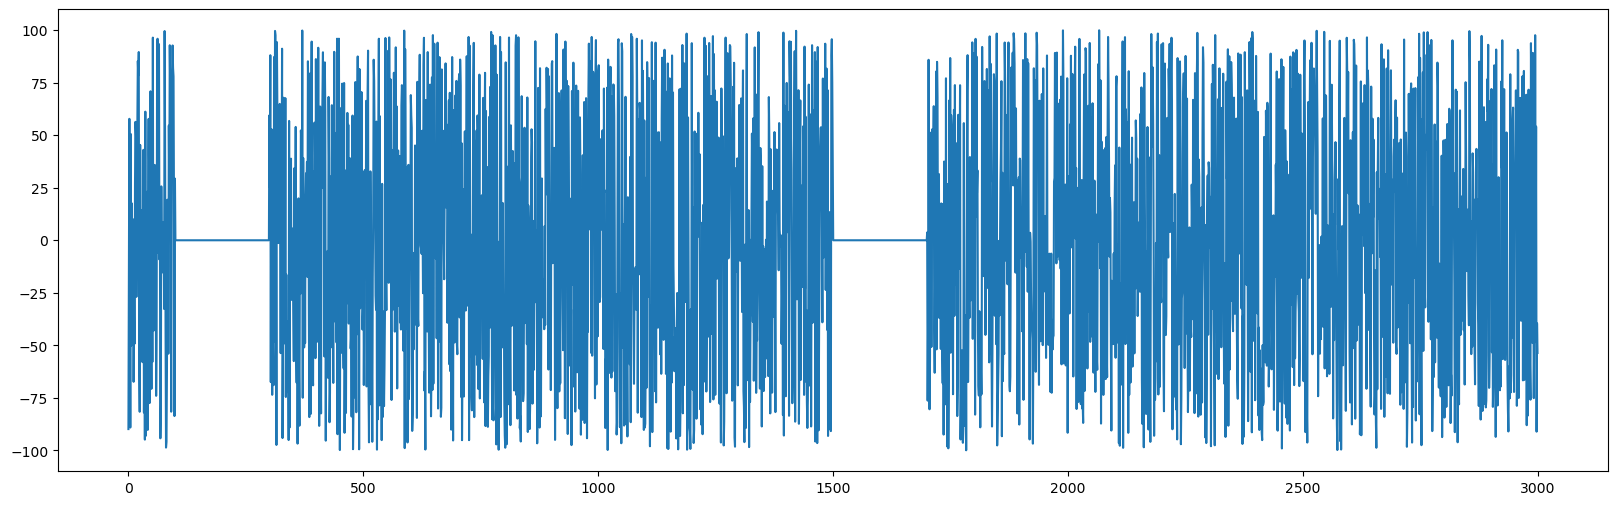

In [2]:
T = np.random.uniform(-100,100,size=3000)
m = 200
i, j = 100, 1500

T[i:i+m] = 0
T[j:j+m] = 0

plt.plot(T)
plt.show()

Here, the subsequences at index `i` and `j` can be considered an anomaly. However, the 1NN distance is 0 for them. Therefore, we may need to investigate other neighbors rather than just 1NN. In discord discovery, it is called twin-freak problem (see [Tutorial](https://cci.drexel.edu/bigdata/bigdata2017/files/Tutorial4.pdf)). It happens when the (same) anomally occurs more than once. In our example above, the anomaly occurs twice. Therefore, we should be able to detect it if we consider 2nd nearest neighbor. 

For further details, see Fig. 2 of the paper.

**Variable-length Top-k $n^{th}$ Discord Discovery:** <br>
Given a time series `T`, a subsequence length-range `[min_m, max_m]`,`K`, and `N`, we want to find **top-k $n^{th}$ discord** for each `k` in $\{1,...,K\}$, for each `n` in $\{1,...,N\}$, and for all `m` in $\{min\_m,...,max\_m\}$.

# 2-Lower Bound of Distance Profile

Lower Bound (LB) for $d_{j,i}^{(m+k)} = d(T_{j,m+k}, T_{i,m+k})$ can be calculated as follows:

**Non-normalized distance (p-norm):**


$$
\begin{align}
LB_{j,i}^{(m+k)} ={}& 
d_{j,i}^{(m)} \quad (1)
\end{align}
$$


**Normalized distance(see eq(2) of the paper):**


$$
\begin{align}
LB_{j,i}^{(m+k)} ={}& 
\frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{
m\left(
1 - \left(\max(\rho^{(m)}_{j,i},0)\right)^{2}
\right)
} \quad (2)
\\
\end{align}
$$


And, the pearson correlation, $\rho^{(m)}_{j,i}$, can be calculated as follows: 


$$
\begin{align}
\rho^{(m)}_{j,i} ={}& 
\frac{\sum \limits_{t=0}^{m-1}{T[i+t]T[j+t]} - m\mu_{i,m}\mu_{j,m}}{m\sigma_{i,m}\sigma_{j,m}} \quad (2a)
\end{align} 
$$


Alternatively, $\rho^{(m)}_{j,i}$ and $d^{(m)}_{j,i}$ are related to each other according to the following formula:


$$
\begin{align}
d^{(m)}_{j,i} ={}& 
\sqrt{
2m \left(
1-\rho^{(m)}_{j,i}
\right)
} \quad {(2b)}
\\
\end{align}
$$


# 3- Core Idea

The core idea of VALMOD can be explained as follows:

## 3-1: Ranked Lower Bound (LB) of Distance Profile 
Ranked LB of distance profile refers to the values of the LB of a distance profile sorted in the ascending order. It is important to note that such ranking is preserved for all subsequence length range `(min_m+1, max_m)` having assumed that they are all being calculated based on the $\rho_{j,i}$ values for length `min_m`.

In other words,<br>
**IF:**


$$
\begin{align}
LB^{(m+k_{1})}_{j,i} \leq{}& 
LB^{(m+k_{1})}_{j,i^{'}}
\\
\end{align}
$$


**THEN:**


$$
\begin{align}
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
LB^{(m+k_{1})}_{j,i} 
\leq{}&
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
LB^{(m+k_{1})}_{j,i'}
\\
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
\left[
\frac{\sigma_{j,m}}{\sigma_{j,m+k_{1}}}
\sqrt{
m\left(
1 - \max(\rho^{(m)}_{j,i},0)^{2}
\right)
}
\right]
\leq{}&
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
\left[
\frac{\sigma_{j,m}}{\sigma_{j,m+k_{1}}}
\sqrt{
m\left(
1 - \max(\rho^{(m)}_{j,i'},0)^{2}
\right)
}
\right]
\\
LB^{(m+k_{2})}_{j,i} \leq{}& 
LB^{(m+k_{2})}_{j,i'}
\\
\end{align}
$$


## 3-2: Accelerating Matrix Profile calculation
Storing all "ranked LB" for all indices requires a significant amount of memory. Instead, we can just store the `top-p` smallest values of the ranked $LB^{(m+k)}_{j}$ and their corresponding indices. The parameter `p` is set by the user (e.g. see Table 2 on page 28). As we will see in the next section, we can use this meta information to skip some unnecessary calculation of distances for length larger than `min_m`.

# 4-VALMOD algorithm
The VALMOD algorithm (see Algorithm1 and Algorithm2 on page 13) discovers variable-length matrix profile and the matrix profile indices. In this section, we implement the functions by taking a bottom-up approach. So, we first implement the functions that are being called by VALMOD algorithm, and then we implement VALMOD algorithm.

## 4-1- ComputeMatrixProfile (see algorith3 on page 15)
This algorithm scans all pairs of subsequences. However, instead of returning the matrix profile and its indices, the algorithm returns the `top-p` smallest value of each distance profile and their corresponding indices.

In the paper, the authors used the LB formula to convert distances to LB. So, as they scan pairs of subsequences,  they calculate LB for each pair of subsequences. The authors used max_heap data structure to store `top-p` smallest LB values for each distance profile. 

**NOTE (1): Our implementation is slightly different than what proposed in the Algorithm3 of the paper**
We can skip line19 of Algorithm 3 provided in the paper. We do NOT need to calculate $LB^{(m+k)}_{j,i}$ for each $d^{(m)}_{j,i}$. As we prove below, the ranked distance profile, $DP^{(m)}_{j}$, is in the same order as its corresponding ranked Lower Bound, $LB^{(m+k)}_{j}$. Therefore, we can simply return the `top-p` smallest value of distance profile and then calculate their corresponding LB value all at once.

**IF:**

$$
\begin{align}
d^{(m)}_{j,i} 
\geq{}&{}
d^{(m)}_{j,i'}
\\
\end{align}
$$



**THEN:**

$$
\begin{align}
\rho^{(m)}_{j,i} 
\leq&{}
\rho^{(m)}_{j,i'}
\\
\max(\rho^{(m)}_{j,i}, 0) 
\leq&{}
\max(\rho^{(m)}_{j,i'},0)
\\
\left(\max(\rho^{(m)}_{j,i}, 0)\right)^{2}
\leq&{}
\left(\max(\rho^{(m)}_{j,i'},0)\right)^{2}
\\
1 - \left(\max(\rho^{(m)}_{j,i}, 0)\right)^{2}
\geq&{}
1 - \left(\max(\rho^{(m)}_{j,i'},0)\right)^{2}
\\
\frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{m
\left[
1 - \left(\max(\rho^{(m)}_{j,i}, 0)\right)^{2}
\right]
}
\geq&{}
\frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{m
\left[
1 - \left(\max(\rho^{(m)}_{j,i'}, 0)\right)^{2}
\right]
}
\\
LB^{(m)}_{j,i} \geq{}& 
LB^{(m)}_{j,i'}
\\
\end{align}
$$



This proves that the ranked distance profile and its ranked lower bound have the same order.

**NOTE (2):** 
<br> 
In STUMPY, parameter `p` is used to denote the kind of p-norm distance. To this end, from this point onwards, we use `k` to denote the number of elements that should be stored for each distance profile.

First, let us implement the naive version of VALMOD, that is we do not take advantage of previously-calculated top-k profiles, and we just iteratively call `stump`.

In [15]:
def naive_VALMOD(T, m_min, m_max):
    # out_P is the scaled version of matrix profile value. 
    n = len(T) - m_min + 1
    out_P = np.full(n, np.inf, dtype=np.float64)
    out_I = np.full(n, -1, dtype=np.int64)
    out_M = np.full(n, -1, dtype=np.int64)
    
    for m in range(m_min, m_max + 1):
        mp = stump(T, m)
        P = mp[:,0].astype(np.float64)
        I = mp[:,1].astype(np.int64)
        
        P[:] = P / np.sqrt(m)
        
        l = len(P)
        mask = P < out_P[:l]
        out_P[:l][mask] = P[mask]
        out_I[:l][mask] = I[mask]
        out_M[:l][mask] = m
    
    out = np.empty((n, 3), dtype=object)
    out[:, 0] = out_P
    out[:, 1] = out_I
    out[:, 2] = out_M
    
    return out

In [5]:
# Example
seed = 0
np.random.seed(seed)
T = np.random.rand(5000)
m_min = 50
m_max = 100

t_start = time.time()
naive_VALMOD(T, m_min, m_max)
t_stop = time.time()

print("The computing time: ", t_stop - t_start)

The computing time:  6.5180253982543945


In [6]:
def _VALMOD_stump(T, m, k):
    """
    Computes the top-1 matrix profile and matrix profile indice, and also computes the lower bound component
    and their coresponding indices.
    
    Parameters
    ----------
    T : numpy.ndarray
        The time series or sequence for which to compute the matrix profile
    
    m : int
        Window size
    
    k : int
        Number of nearest neighbors to consider in constructing the profiles and lower bounds.
    
    Returns
    -------
    out 1: np.ndarray
        A 1D array containing the exact matix profile values
    
    out 2: np.ndarray
        A 1D array containing the exact matix profile indices
        
    out 3: np.ndarray
        A 2D array, with k columns, containing the core component of lowerbound values,
        
    out 4 : np.ndarray
        A 2D array, with k columns, containing the indices that correspond to the lowerbound values
    """
    mp = stump(T, m, k=k)
    P_TopK = mp[:, :k].astype(np.float64)
    I_TopK = mp[:, k:2*k].astype(np.int64)
    
    # In VALMOD paper, LB has the following component:
    # np.sqrt(m * (1 - np.square(ρ_clip))). Here, we
    # show it by `LB_σr`

    ρ = 1.0 - np.square(P_TopK) / (2 * m)
    ρ_clipped = np.clip(ρ, a_min=0.0, a_max=1.0)
    r = np.sqrt(m * (1.0 - np.square(ρ_clipped))) 
    _, σ = core.compute_mean_std(T, m)
    LB_σr = σ.reshape(-1,1) * r
    
    return P_TopK[:, 0], I_TopK[:, 0], LB_σr, I_TopK
    
    
    
def _VALMOD_stump_partial(T, m, k, LB_σr, LB_I):
    """
    Compute partial matrix profile for subsequence length `m`, 
    with help of lowerbound. 
    
    Parameters
    ----------
    T : numpy.ndarray
        The time series or sequence for which to compute the matrix profile
    
    m : int
        Window size
    
    k : int
        The number of nearest neighbor to consider for constructing lowerbound 
        profiles
    
    LB_ar : np.ndarray
        The array that contains the main component of lowerbound values
    
    I_TopK : np.ndarray
        The array that corresponds to the indices of lower bound values
        
    Returns
    -------
    P : np.ndarray
        A 1D array containing the exact matix profile values
    
    I : np.ndarray
        A 1D array containing the exact matix profile indices
        
    LB_σr : np.ndarray
        A 2D array, with k columns, containing the core component of lowerbound values,
    
    LB_I : np.ndarray
        A 2D array, with k columns, containing the indices that correspond to the lowerbound values
    """
    n = len(T) - m + 1
    P = np.full(n, np.inf,dtype=np.float64)
    I = np.full(n, -1,dtype=np.int64)
    is_mp_valid = np.full(n, 0, dtype=bool)
    
    # may add support for `T_B` (AB-join)
    Q, μ_Q, σ_Q, Q_subseq_isconstant = core.preprocess(T, m)
    T, M_T, Σ_T, T_subseq_isconstant = core.preprocess(T, m)
    
    σ_Q_inv = 1.0 / σ_Q
    LB = σ_Q_inv.reshape(-1, 1) * LB_σr[:len(σ_Q_inv)]
     
    global_min_maxLB = np.inf
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    for i in range(n):
        excl_zone_start = max(i - excl_zone, 0)
        excl_zone_stop = min(i + excl_zone + 1, n)
        excl_zone_range = range(excl_zone_start, excl_zone_stop)
        
        min_dist = np.inf
        idx = -1
        maxLB = LB[i, -1]
        for enum, j in enumerate(LB_I[i]):
            if j >= n or j in excl_zone_range:
                continue
            
            QT = np.dot(T[i:i+m], T[j:j+m])
            d_square = core._calculate_squared_distance(
                m,
                QT,
                μ_Q[i],
                σ_Q[i],
                M_T[j],
                Σ_T[j],
                Q_subseq_isconstant[i],
                T_subseq_isconstant[j],
            )
            d = np.sqrt(d_square)
            if d < min_dist:
                min_dist = d
                idx = j
        
        if min_dist < maxLB:
            P[i] = min_dist
            I[i] = idx
            is_mp_valid[i] = True
        else:
            global_min_maxLB = min(global_min_maxLB, maxLB)
            is_mp_valid[i] = False
                
    n_invalid = np.sum(~is_mp_valid)
    time_complexity_threshold = (n * np.log2(k) / np.log2(n))
    
    global_min_dist = np.min(P)
    if global_min_dist > global_min_maxLB:
        if n_invalid < time_complexity_threshold:
            for idx in np.flatnonzero(~is_mp_valid):
                if global_min_dist <= maxLB_profile[idx]:
                    continue  # Q: so, are we considering approx. best match?

                QT = core.sliding_dot_product(T[idx:idx+m], T)
                D = core._mass(
                    T[idx:idx+m], 
                    T, 
                    QT, 
                    μ_Q[idx], 
                    σ_Q[idx], 
                    M_T, 
                    Σ_T, 
                    Q_subseq_isconstant[idx], 
                    T_subseq_isconstant
                )
                core.apply_exclusion_zone(D, idx, m, np.inf)

                arg = np.argmin(D)
                if D[arg] < np.inf:
                    P[idx] = D[arg]
                    I[idx] = arg

                args_topk = np.argsort(D)[:k]
                LB_I[idx] = args_topk

                ρ = 1.0 - np.square(D[args_topk]) / (2 * m)
                ρ_clipped = np.clip(ρ, a_min=0.0, a_max=1.0)
                r = np.sqrt(m * (1 - np.square(ρ_clipped)))
                LB_σr[idx] = σ_Q[idx] * r

        else:
            mp = stump(T, m, k=k)
            P_TopK = mp[:, :k].astype(np.float64)
            I_TopK = mp[:, k:2*k].astype(np.int64)

            ρ = 1.0 - np.square(P_TopK) / (2 * m)
            ρ_clipped = np.clip(ρ, a_min=0.0, a_max=1.0)
            r = np.sqrt(m * (1 - np.square(ρ_clipped)))
            _, σ = core.compute_mean_std(T, m)
            LB_σr = σ.reshape(-1,1) * r
            LB_I = I_TopK
    
    return P, I, LB_σr, LB_I

In [7]:
def  _update_PIM(P, P_new, I, I_new, M, m_new):
    """
    Update P (profile values), I (profile indices), M (length of subsequences), in place, 
    by using the new values `P_new`, `I_new`, `m_new`
    
    Parameters
    ----------
    P : np.ndarray
        The matrix profile value containing the scaled distance between a subsequence to the nearest neighbor
        
    P_new : np.ndarray
        The matrix profile value containing the scaled distance between a subsequence to the nearest neighbor, 
        computed for a subsequence length that is longer than the one used for `P`
    
    I : np.ndarray
        The matrix profile indices containing the nearest neighbor index of each subsequence
    
    I_new : np.ndarray
        The matrix profile indices containing the nearest neighbor index of each subsequence, computed 
        for a subsequence length that is longer than the one used for `I`. These indices correspond to 
        the matrix profile `P_new`
        
    M : np.ndarray
        For a subequence at index `i`, `M[i]` is the lenght of subsequence for which the lowest distance 
        between `i` and its nearest neighbor is discovered.
        
    m_new : int
        The new subsequence length that is used for computing P_new, I_new
    
    Returns 
    -------
    None
    """
    n = len(P_new)
    mask = P_new < P[:n]
    P[:n][mask] = P_new[mask]
    I[:n][mask] = I_new[mask]
    M[:n][mask] = m_new

In [8]:
def VALMOD(T, m_min, m_max, k):
    """
    This function finds the matrix profile of T_A while considering different length of subsequences in 
    range `[m_min, m_max]` inclusive. To be able to compare distances across different subsequence length, 
    each distance is scaled by a factor of `1 / sqrt(m)`. 
    
    Parameters
    T : np.ndarray
        The timeseries of interest
    
    m_min : int
        The smallest window size
        
    m_max : int
        The largest window size
    
    k : int
        The number of nearest neighbors to capture for speeding up the computaion.
        
    Return
    ------
    PIM : np.ndarray
        A 2D array, with exactly three columns, representing the ensembled matrix profile. The first column 
        contains the ensembled matrix profile value. The second column contains their corresponding nearest
        neighbor index, and the third (last) column contains the corresponding subsequence length. Hence, 
        for instance, when `dist = PIM[i, 0]`, `j = PIM[i, 1]`, and `m = PIM[i, 2]`, then `dist` is a (scaled) 
        distance between subsequence `S_i` and subsequence `S_j`, each with length `m`. `dist` is the lowest 
        scaled distance between `S_i` and all of its neighbors considering all values of `m`.
    """
    n = len(T) - m_min + 1
    out_P = np.full(n, np.inf, dtype=np.float64)
    out_I = np.full(n, -1, dtype=np.int64)
    out_M = np.full(n, -1, dtype=np.int64)
    
    # out_P, out_I, out_M = _update_PIM(out_P, P_TopK[:,0] / np.sqrt(m), out_I, I_TopK[:, 0], out_M, m)
    LB_σr = None
    for m in range(m_min, m_max + 1):
        if LB_σr is None:  # only runs for the first iteration, i,e, lowest `m` 
            P, I, LB_σr, LB_I = _VALMOD_stump(T, m, k)
        else:
            P, I, LB_σr, LB_I = _VALMOD_stump_partial(T, m, k, LB_σr, LB_I)
            
        _update_PIM(out_P, P/np.sqrt(m), out_I, I, out_M, m)
    
    out = np.empty((n, 3), dtype=object)
    out[:, 0] = out_P
    out[:, 1] = out_I
    out[:, 2] = out_M
    
    return out

In [9]:
k=20

t_start = time.time()
valmod_mp = VALMOD(T, m_min, m_max, k)
t_stop = time.time()

print("Computing time: ", t_stop - t_start)

Computing time:  98.4311773777008


In [16]:
ref = naive_VALMOD(T, m_min, m_max)
comp = VALMOD(T, m_min, m_max, k=10)

In [25]:
# np.testing.assert_almost_equal(ref, comp)
# results in error as the paper's proposed method is approx. 
# However, the global min is exact. 

In [23]:
idx=np.argmin(ref[:,0])
ref[idx]

array([0.8414941313430254, 2031, 51], dtype=object)

In [24]:
idx=np.argmin(comp[:,0])
comp[idx]

array([0.841494131343025, 2031, 51], dtype=object)